## Ou-Carter mehod
[J. Chem. Theory Comput. 2018, 14, 5680−5689](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.8b00717?casa_token=j3Gzwpzmt0oAAAAA:9PQdZFfkeoICbYk_aXhoPGve8cMwNNmnqTCpsHbN2YrBD-mldE2plJ_iKSUod-w1gUBoIvtUXSPgAGib)

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True}) # Set save_jk to be True is currently necessary to give Inverter information
                                     # For hartree
psi4.set_memory(int(2.50e10))
psi4.set_num_threads(4)
psi4.core.clean()

import n2v


  Memory set to  23.283 GiB by Python driver.
  Threads set to 4 by Python driver.


First, build the input wavefunction using Psi4.

In [2]:
Ne = psi4.geometry( 
""" 
Ne
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf",
                  'DFT_SPHERICAL_POINTS': 350,  # Usually specify the DFT spherical grid is highly recommended.
                  'DFT_RADIAL_POINTS': 210,  # See [https://psicode.org/psi4manual/master/dft.html] for options.
                  'CUBIC_BASIS_TOLERANCE': 1e-21, 
                  'DFT_BASIS_TOLERANCE': 1e-21, 
                 })  # Spin-Restricted

wfn = psi4.properties("CCSD/cc-pcvqz", return_wfn=True, molecule=Ne, properties=["dipole"])[1]
ine = n2v.Inverter(wfn)

Build the plotting grid for vxc:

In [3]:
x = np.linspace(-5,10,1501) + 1e-7
y = [0]
z = [0]
grid, shape = ine.generate_grids(x,y,z)

Detailed explaination can be found in [J. Chem. Theory Comput. 2018, 14, 5680−5689](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.8b00717?casa_token=j3Gzwpzmt0oAAAAA:9PQdZFfkeoICbYk_aXhoPGve8cMwNNmnqTCpsHbN2YrBD-mldE2plJ_iKSUod-w1gUBoIvtUXSPgAGib).

$v_{XC}$ is updated self-consistently in:
$$v_{XC}(r)=\bar{\epsilon}^{\rm KS}(r) + \frac{\nabla^2 n_{in}(r)}{4n_{in}(r)}  - \frac{|\nabla n_{in}(r)|^2}{8|n_{in}(r)|^2} -\frac{\tau^{\rm KS}_P(r)}{n^{\rm KS}(r)} -\tilde{v}_{ext}(r) - v_{\textrm{H},\rm in}(r).$$

$\tilde{v}_{ext}(r)$ is the effiective external potential obtained by SVWN calculations [J. Chem. Theory Comput. 2013, 9, 9, 3959–3964](https://pubs.acs.org/doi/abs/10.1021/ct4004146):
$$\tilde{v}_{ext}(r) = \bar{\epsilon}^{\rm KS}(r) - \frac{\tau^{LDA}_L(r)}{n^{LDA}(r)} - v_{H}^{LDA}(r) - v_{xc}^{LDA}(r),$$

which is done in Inverter._get_optimized_external_potential() as shown in below. The main idea of this is to eliminate the error introduced by the finite basis set.

Since the self-consistent calculaiton of OuCarter method is not even as easy as KS-DFT, a good initial guess is usually important for a good result. This can be set in the keyword **init**, which is set to be SCAN in below.

**frac_old** is another convertional method to stabilize the convergence by mixing old with new. This is set as 0.9 below, which means that the new vxc will only contribute 10%. A large **frac_old** seems to be important to stablize $\tau_P$.

Since OuCarter is by design calculated on the DFT spherical grid, a separate grid can be provide to other purposes like plotting in **vxc_grid**.
Let's do the calculation:

In [4]:
v = ine.invert("OC", vxc_grid=grid, opt_max_iter=21, frac_old=0.9, init="SCAN")

Iter: 1, Density Change: 1.95e-04, Eigenvalue Change: 6.16e+00.
Iter: 2, Density Change: 3.43e-06, Eigenvalue Change: 1.52e-01.
Iter: 3, Density Change: 4.93e-07, Eigenvalue Change: 9.32e-04.
Iter: 4, Density Change: 3.86e-07, Eigenvalue Change: 7.82e-04.
Iter: 5, Density Change: 3.02e-07, Eigenvalue Change: 6.61e-04.
Iter: 6, Density Change: 2.36e-07, Eigenvalue Change: 5.62e-04.
Iter: 7, Density Change: 1.84e-07, Eigenvalue Change: 4.81e-04.
Iter: 8, Density Change: 1.43e-07, Eigenvalue Change: 4.14e-04.
Iter: 9, Density Change: 1.11e-07, Eigenvalue Change: 3.60e-04.
Iter: 10, Density Change: 8.63e-08, Eigenvalue Change: 3.14e-04.
Iter: 11, Density Change: 6.73e-08, Eigenvalue Change: 2.77e-04.
Iter: 12, Density Change: 5.28e-08, Eigenvalue Change: 2.45e-04.
Iter: 13, Density Change: 4.18e-08, Eigenvalue Change: 2.19e-04.
Iter: 14, Density Change: 3.37e-08, Eigenvalue Change: 1.96e-04.
Iter: 15, Density Change: 2.78e-08, Eigenvalue Change: 1.77e-04.
Iter: 16, Density Change: 2.35e-08

Take a look at the effective external potential $\tilde{v}_{ext}(r)$. This is return by ine.invert("OC") but we can redo the calculation:

Turning grid to psi4 blocks:

In [5]:
grid_info = ine.grid_to_blocks(grid)  # turing grid into psi4 block infomation
grid_info[-1].set_pointers(wfn.Da())

Get exact external potential and effective potential:

In [6]:
vext = ine.on_grid_esp(grid=grid_info)[0]
vext_eff = ine._get_optimized_external_potential(grid_info=grid_info)[-1]

(-4.0, 4.0)

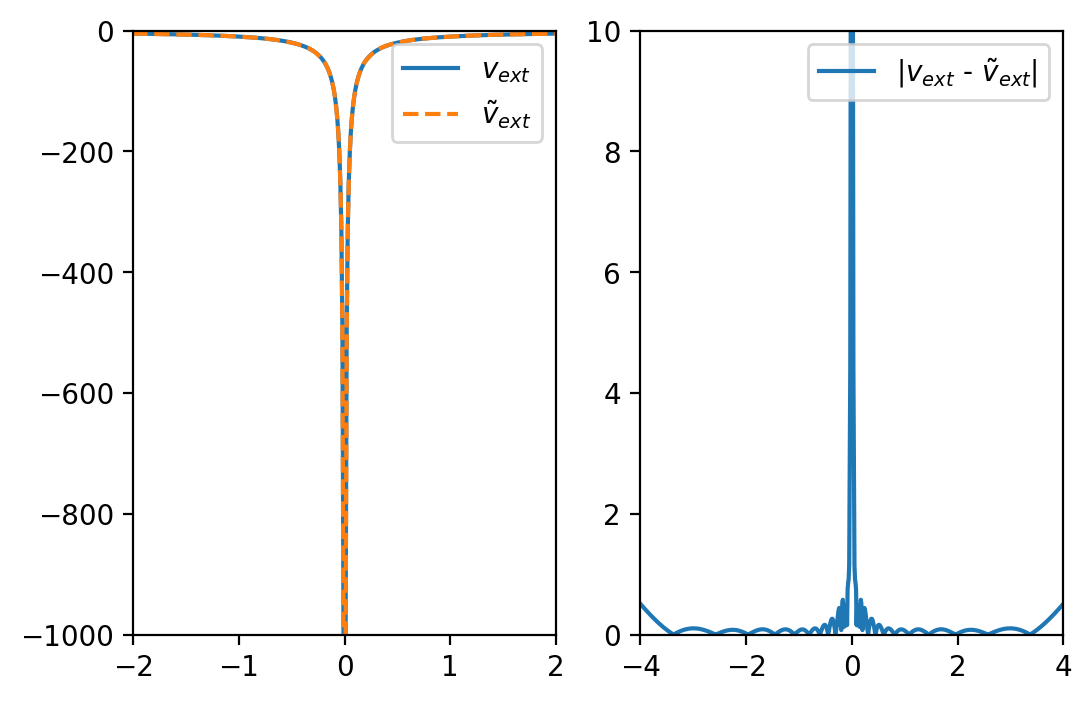

In [7]:
fig, ax = plt.subplots(1, 2, dpi=200)
ax[0].plot(x, vext, label="$v_{ext}$")
ax[0].plot(x, vext_eff, ls="--", label="$\\tilde{v}_{ext}$")
ax[0].legend()
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-1000, 0)

ax[1].plot(x, np.abs(vext-vext_eff), label="$|v_{ext}$ - $\\tilde{v}_{ext}|$")
ax[1].legend()
ax[1].set_ylim(0, 10)
ax[1].set_xlim(-4, 4)

Let's plot things out. The function will return $v_{xc}$, $\bar{\epsilon}$, $\frac{\tau_{L} - \tau_{P}}{n_{in}}$, $\frac{\tau_{P}}{n_{in}}$, $\tilde v_{ext}$, $v_H$, and const_shift. Constant shift is the constant updated in each iteration to make sure the eigen value of OuCarter output is the same as input, in order to make sure that the potential is not wildly shifted.

-0.00196216369031621
-0.3385773364054473
-0.8509457106750598
0.5204062529789938


(-10.0, 1.0)

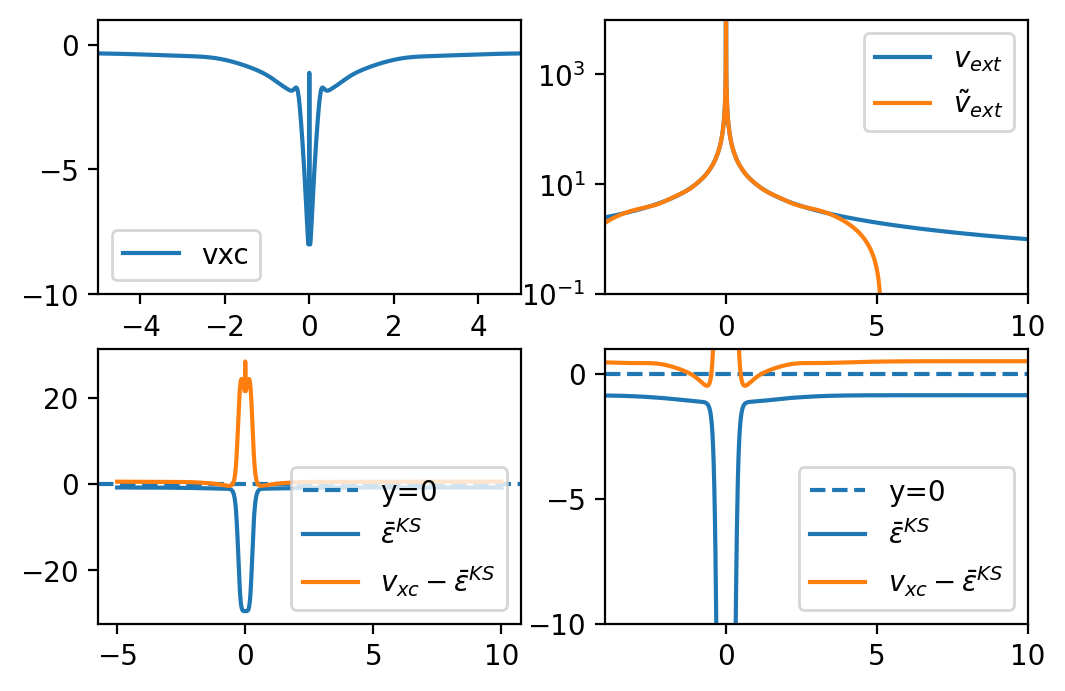

In [8]:
print(v[-1])
fig, ax = plt.subplots(2,2,dpi=200)
# ax[0,0].plot(Ne_xyz, Ne_vxc, label="QMC")
ax[0,0].plot(x, v[0], label='vxc')
ax[0,0].set_ylim(-10, 1)
ax[0,0].set_xlim(-5,5)
# ax[0,0].set_xscale('log')
ax[0,0].legend()
print(v[0][-1])


ax[0,1].plot(x, -vext, label="$v_{ext}$")
ax[0,1].plot(x, -vext_eff, label="$\\tilde{v}_{ext}$")
ax[0,1].set_xlim(-4, 10)
ax[0,1].set_ylim(1e-1, 1e4)
ax[0,1].set_yscale('log')
ax[0,1].legend()
print(v[1][-1])

ax[1,0].axhline(y=0, ls='--', label='y=0')
ax[1,0].plot(x, v[1], label='$\\bar{\epsilon}^{KS}$')
ax[1,0].plot(x, -v[2]-v[4]-v[3]-v[5], label="$v_{xc} - \\bar{\epsilon}^{KS}$")
ax[1,0].legend(loc='lower right')
print((-v[2] - v[4] - v[5])[-1])

ax[1,1].axhline(y=0, ls='--', label='y=0')
ax[1,1].plot(x, v[1], label='$\\bar{\epsilon}^{KS}$')
ax[1,1].plot(x, -v[2]-v[4]-v[3]-v[5], label="$v_{xc} - \\bar{\epsilon}^{KS}$")
ax[1,1].legend()
ax[1,1].set_xlim(-4, 10)
ax[1,1].set_ylim(-10, 1)

# fig.savefig("OuCarter_Ne.pdf")